In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import cartopy.crs as ccrs
from pyresample.geometry import AreaDefinition
from pyresample.geometry import GridDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition, area_def2basemap
from pyresample.kd_tree import resample_nearest
#from scipy import spatial
sys.path.append('../saildrone/subroutines/')
from read_routines import read_all_usv, read_one_usv, add_coll_vars,get_filelist_l2p,get_orbital_data_l2p
import warnings
warnings.simplefilter('ignore') # filter some warning messages
from glob import glob

# Read in All Saildrone cruises downloaded from https://data.saildrone.com/data/sets
- 2017 onwards, note that earlier data is going to lack insruments and be poorer data quality in general
- For this code I want to develop a routine that reads in all the different datasets and creates a standardized set
- It may work best to first read each of the files individually into a dictionary 
- then go through each dataset finding all variable names
- I decided to put all SST into TEMP_CTD_MEAN and same for Salinity so there is a single variable name
- this still preserves all the dataset information

In [5]:
#dir_data = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/' #'f:/data/cruise_data/saildrone/saildrone_data/'
#dir_data_pattern = 'C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data/Arctic/saildrone_usv_data/*.nc' 
#dir_data_pattern = 'F:/data/cruise_data/saildrone/saildrone_data/'
dir_data_pattern = 'C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data/*.nc'

dir_out = 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day/'
dir_out2 = 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest/'

data_dict = read_all_usv(dir_data_pattern)
#data_dict = add_coll_vars(data_dict)


number of file: 46


# Check on lat/lon range, names, etc.

In [ ]:
#RSS test open
#file = 'F:/data/sat_data/smap/SSS/L3/RSS/V4/8day_running/SCI/2016/001/RSS_smap_SSS_L3_8day_running_2016_005_FNL_v04.0.nc'
#ds = xr.open_dataset(file)
#ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
#ds = ds.sortby(ds.lon)
#ds.close()  


# Collocate SMAP RSS 8day

In [6]:
#RSS
#get list of all filenames in directory
adir = 'F:/data/sat_data/smap/SSS/L3/RSS/V4/8day_running/SCI/**/**/*.nc'
files = [x for x in glob(adir)]
print('number of file:',len(files))

ds = xr.open_mfdataset(files,combine='nested',concat_dim='time')
ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
ds = ds.sortby(ds.lon)
ds.close()  


number of file: 1863


In [7]:
#RSS doesn't produce empty files when the satellite is missing data & this causes all sorts of problems
#this code creates empty data and puts it in the place of missing data files
ds_sat = ds
ds_sat2=[]
empty = ds_sat.isel(time=0)
for var in empty:
    empty[var]=empty[var]*np.nan
for i,t in enumerate(ds_sat.time):
    if i<len(ds_sat.time)-1:
        tdif = int((ds_sat.isel(time=i+1).time.data-ds_sat.isel(time=i).time.data)/np.timedelta64(1,'D'))
        ds_sat2.append(ds_sat.isel(time=i))
        for inc in range(tdif-1):
            dy = ds_sat.isel(time=i).time.data+np.timedelta64(inc+1,'D')
            empty = empty.assign_coords(time=dy) #empty['time']=dy
            ds_sat2.append(empty)
ds_sat2 = xr.concat(ds_sat2,dim='time')
ds = ds_sat2

In [12]:
len(ds_sat2.time)

1903

# Collocate using .interp linear interpolation

In [8]:
%%time
for iname,name in enumerate(data_dict):
    print(iname)
    ds_usv = data_dict[name].copy(deep=True)
    ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    tem = ds_usv.lat.ffill(dim='time')
    tem = ds_usv.lat.bfill(dim='time')
    t1,t2=ds_usv.time.min().data-np.timedelta64(8,'D'),ds_usv.time.max().data+np.timedelta64(8,'D')
    x1,x2=ds_usv.lon.min().data,ds_usv.lon.max().data
    y1,y2=ds_usv.lat.min().data,ds_usv.lat.max().data
    print(t1,t2)
    ds_sat = ds.sel(time=slice(t1,t2),lat=slice(y1,y2),lon=slice(x1,x2)).load()   
    ds_interp = ds_sat.interp(time=ds_usv.time,lat=ds_usv.lat,lon=ds_usv.lon,method='linear')#.interp(method='nearest')

    #add saildrone data to interpolated sat data
    ds_interp = ds_interp.reset_coords(names={'lat','lon'})
    for var in ds_interp:
        ds_usv['sat_'+var]=ds_interp[var]
    #output
    fout = dir_out+name+'_RSS8dy_20210413.nc'
    ds_usv.to_netcdf(fout)
    

0
2015-05-04T20:00:16.000000000 2015-08-05T19:58:16.000000000
1
2015-04-26T00:00:15.000000000 2015-08-05T19:58:16.000000000
2
2016-05-15T00:01:15.000000000 2016-09-11T18:02:15.000000000
3
2016-05-15T00:01:15.000000000 2016-09-11T18:02:15.000000000
4
2018-04-03T18:00:00.000000000 2018-06-19T05:57:00.000000000
5
2018-03-07T00:00:00.000000000 2018-06-06T23:59:00.000000000
6
2018-03-07T00:00:00.000000000 2018-06-25T23:59:00.000000000
7
2019-05-17T00:00:00.000000000 2019-10-29T23:59:00.000000000
8
2019-01-11T04:00:00.000000000 2019-08-11T04:30:00.000000000
9
2019-05-06T23:00:00.000000000 2019-10-19T18:30:00.000000000
10
2019-05-06T23:00:00.000000000 2019-10-19T18:30:00.000000000
11
2019-10-10T10:12:00.000000000 2020-07-25T13:45:00.000000000
12
2019-10-10T11:00:00.000000000 2020-07-25T13:45:00.000000000
13
2020-01-09T00:00:00.000000000 2020-03-10T23:59:00.000000000
14
2020-01-09T00:00:00.000000000 2020-03-10T23:59:00.000000000
15
2020-01-09T00:00:00.000000000 2020-03-10T23:59:00.000000000
16

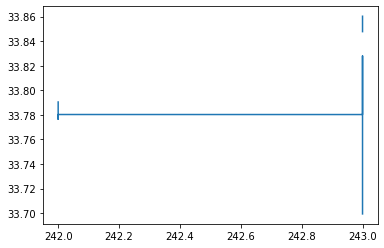

In [9]:
plt.plot(ds_usv.time.dt.dayofyear,ds_usv.sat_sss_smap)

# Collocate using .interp nearest neighbor interpolation

In [10]:
%%time
for iname,name in enumerate(data_dict):
    print(iname)
    ds_usv = data_dict[name].copy(deep=True)
    ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    tem = ds_usv.lat.ffill(dim='time')
    tem = ds_usv.lat.bfill(dim='time')
    t1,t2=ds_usv.time.min().data-np.timedelta64(8,'D'),ds_usv.time.max().data+np.timedelta64(8,'D')
    x1,x2=ds_usv.lon.min().data,ds_usv.lon.max().data
    y1,y2=ds_usv.lat.min().data,ds_usv.lat.max().data
    print(t1,t2)
    ds_sat = ds.sel(time=slice(t1,t2),lat=slice(y1,y2),lon=slice(x1,x2)).load()   
    ds_interp = ds_sat.interp(time=ds_usv.time,lat=ds_usv.lat,lon=ds_usv.lon,method='nearest')#.interp(method='nearest')

    #add saildrone data to interpolated sat data
    ds_interp = ds_interp.reset_coords(names={'lat','lon'})
    ds_interp['sat_time']=ds_interp.time
    for var in ds_interp:
        ds_usv['sat_'+var]=ds_interp[var]
    #output
    fout = dir_out2+name+'_RSS8dy_20210413.nc'
    ds_usv.to_netcdf(fout)

0
2015-05-04T20:00:16.000000000 2015-08-05T19:58:16.000000000
1
2015-04-26T00:00:15.000000000 2015-08-05T19:58:16.000000000
2
2016-05-15T00:01:15.000000000 2016-09-11T18:02:15.000000000
3
2016-05-15T00:01:15.000000000 2016-09-11T18:02:15.000000000
4
2018-04-03T18:00:00.000000000 2018-06-19T05:57:00.000000000
5
2018-03-07T00:00:00.000000000 2018-06-06T23:59:00.000000000
6
2018-03-07T00:00:00.000000000 2018-06-25T23:59:00.000000000
7
2019-05-17T00:00:00.000000000 2019-10-29T23:59:00.000000000
8
2019-01-11T04:00:00.000000000 2019-08-11T04:30:00.000000000
9
2019-05-06T23:00:00.000000000 2019-10-19T18:30:00.000000000
10
2019-05-06T23:00:00.000000000 2019-10-19T18:30:00.000000000
11
2019-10-10T10:12:00.000000000 2020-07-25T13:45:00.000000000
12
2019-10-10T11:00:00.000000000 2020-07-25T13:45:00.000000000
13
2020-01-09T00:00:00.000000000 2020-03-10T23:59:00.000000000
14
2020-01-09T00:00:00.000000000 2020-03-10T23:59:00.000000000
15
2020-01-09T00:00:00.000000000 2020-03-10T23:59:00.000000000
16

In [ ]:
plt.plot(ds_usv.time.dt.dayofyear,ds_usv.sat_sss_smap)

# Collocation SMAP JPL 8day

In [11]:
#JPL
adir = 'F:/data/sat_data/smap/SSS/L3/JPL/V4.3/8day_running/**/**/*4.3.nc'
files = [x for x in glob(adir)]
print('number of file:',len(files))

ds = xr.open_mfdataset(files,combine='nested',concat_dim='time')
ds = ds.rename({'latitude':'lat','longitude':'lon'})
ds = ds.sortby(ds.lat)
ds.close()  
ds

number of file: 1907


<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, time: 1907)
Coordinates:
  * lat                   (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                   (lon) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * time                  (time) datetime64[ns] 2015-04-04T12:00:00 ... 2020-...
Data variables:
    smap_sss              (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    anc_sss               (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    anc_sst               (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    smap_spd              (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    smap_high_spd         (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    weight                (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    land_fraction         (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ice_concentration     (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    smap_sss_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes:
    title:                       SMAP 0.25x0.25 deg grid averaged 8-day SSS/WSPD
    institution:                 Jet Propulsion Laboratory
    source:                      SMAP L2B SSS
    history:                     DATA_SOURCE_VERSION V4.3 L2B SMAP SSS/WSPD
    comment:                     Gaussian-weighted map gridding of SMAP L2B S...
    Gaussian_window_radius:      45.0
    Gaussian_window_half_power:  30.0
    revs_used:                   [870 871 872 873 874 875 876 877 878 879 880...
    revs_missing:                [864 865 866 867 868 869 881 882 908 909 910...
    l2b_files:                   SMAP_L2B_SSS_00870_20150401T004402_R16010_V4...
    TB_CRID:                     R16000
    Year:                        2015
    Month:                       4
    Day:                         4
    Days_averaged:               8.0
    Conventions:                 CF-1.6, ACDD-1.3
    processing_level:            3
    cdm_data_type:               Grid
    date_issued:                 2020-021T19:38:46.014
    date_created:                2020-021T19:38:46.014
    time_coverage_start:         2015-090T12:00:00.000
    time_coverage_end:           2015-098T12:00:00.000
    geospatial_lat_max:          90.0
    geospatial_lat_min:          -90.0
    geospatial_lon_max:          180.0
    geospatial_lon_min:          -180.0
    geospatial_lat_units:        degrees_north
    geospatial_lon_units:        degrees_east
    platform:                    SMAP
    sensor:                      SMAP
    project:                     SMAP
    product_version:             V4.3
    keywords_vocabulary:         http://gcmd.gsfc.nasa.gov/Resources/valids/g...
    keywords:                    SEA SURFACE SALINITY, SALINITY, SMAP, Jet Pr...
    creator_name:                JPL
    creator_email:               fore@jpl.nasa.gov
    publisher_name:              Alexander G. Fore
    publisher_email:             fore@jpl.nasa.gov
    contributor_name:            Alexander Fore, Simon Yueh, Wenqing Tang, Ak...
    references:                  10.1109/TGRS.2016.2601486, 10.1109/TGRS.2016...

In [13]:
%%time
for iname,name in enumerate(data_dict):
    print(iname)
    ds_usv = data_dict[name].copy(deep=True)
    ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    tem = ds_usv.lat.ffill(dim='time')
    tem = ds_usv.lat.bfill(dim='time')
    t1,t2=ds_usv.time.min().data-np.timedelta64(8,'D'),ds_usv.time.max().data+np.timedelta64(8,'D')
    x1,x2=ds_usv.lon.min().data,ds_usv.lon.max().data
    y1,y2=ds_usv.lat.min().data,ds_usv.lat.max().data
    print(t1,t2)
    ds_sat = ds.sel(time=slice(t1,t2),lat=slice(y1,y2),lon=slice(x1,x2)).load()   
    ds_interp = ds_sat.interp(time=ds_usv.time,lat=ds_usv.lat,lon=ds_usv.lon,method='linear')#.interp(method='nearest')
    #add saildrone data to interpolated sat data
    ds_interp = ds_interp.reset_coords(names={'lat','lon'})
    for var in ds_interp:
        ds_usv['sat_'+var]=ds_interp[var]    
    fout = dir_out+name+'_JPL8dy_20210413.nc'
    ds_usv.to_netcdf(fout)

0
2015-05-04T20:00:16.000000000 2015-08-05T19:58:16.000000000
1
2015-04-26T00:00:15.000000000 2015-08-05T19:58:16.000000000
2
2016-05-15T00:01:15.000000000 2016-09-11T18:02:15.000000000
3
2016-05-15T00:01:15.000000000 2016-09-11T18:02:15.000000000
4
2018-04-03T18:00:00.000000000 2018-06-19T05:57:00.000000000
5
2018-03-07T00:00:00.000000000 2018-06-06T23:59:00.000000000
6
2018-03-07T00:00:00.000000000 2018-06-25T23:59:00.000000000
7
2019-05-17T00:00:00.000000000 2019-10-29T23:59:00.000000000
8
2019-01-11T04:00:00.000000000 2019-08-11T04:30:00.000000000
9
2019-05-06T23:00:00.000000000 2019-10-19T18:30:00.000000000
10
2019-05-06T23:00:00.000000000 2019-10-19T18:30:00.000000000
11
2019-10-10T10:12:00.000000000 2020-07-25T13:45:00.000000000
12
2019-10-10T11:00:00.000000000 2020-07-25T13:45:00.000000000
13
2020-01-09T00:00:00.000000000 2020-03-10T23:59:00.000000000
14
2020-01-09T00:00:00.000000000 2020-03-10T23:59:00.000000000
15
2020-01-09T00:00:00.000000000 2020-03-10T23:59:00.000000000
16

In [14]:
%%time
for iname,name in enumerate(data_dict):
    print(iname)
    ds_usv = data_dict[name].copy(deep=True)
    ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    tem = ds_usv.lat.ffill(dim='time')
    tem = ds_usv.lat.bfill(dim='time')
    t1,t2=ds_usv.time.min().data-np.timedelta64(8,'D'),ds_usv.time.max().data+np.timedelta64(8,'D')
    x1,x2=ds_usv.lon.min().data,ds_usv.lon.max().data
    y1,y2=ds_usv.lat.min().data,ds_usv.lat.max().data
    print(t1,t2)
    ds_sat = ds.sel(time=slice(t1,t2),lat=slice(y1,y2),lon=slice(x1,x2)).load()   
    ds_interp = ds_sat.interp(time=ds_usv.time,lat=ds_usv.lat,lon=ds_usv.lon,method='nearest')#.interp(method='nearest')
    #add saildrone data to interpolated sat data
    ds_interp = ds_interp.reset_coords(names={'lat','lon'})
    for var in ds_interp:
        ds_usv['sat_'+var]=ds_interp[var]
    fout = dir_out2+name+'_JPL8dy_20210413'+'.nc'
    ds_usv.to_netcdf(fout)

0
2015-05-04T20:00:16.000000000 2015-08-05T19:58:16.000000000
1
2015-04-26T00:00:15.000000000 2015-08-05T19:58:16.000000000
2
2016-05-15T00:01:15.000000000 2016-09-11T18:02:15.000000000
3
2016-05-15T00:01:15.000000000 2016-09-11T18:02:15.000000000
4
2018-04-03T18:00:00.000000000 2018-06-19T05:57:00.000000000
5
2018-03-07T00:00:00.000000000 2018-06-06T23:59:00.000000000
6
2018-03-07T00:00:00.000000000 2018-06-25T23:59:00.000000000
7
2019-05-17T00:00:00.000000000 2019-10-29T23:59:00.000000000
8
2019-01-11T04:00:00.000000000 2019-08-11T04:30:00.000000000
9
2019-05-06T23:00:00.000000000 2019-10-19T18:30:00.000000000
10
2019-05-06T23:00:00.000000000 2019-10-19T18:30:00.000000000
11
2019-10-10T10:12:00.000000000 2020-07-25T13:45:00.000000000
12
2019-10-10T11:00:00.000000000 2020-07-25T13:45:00.000000000
13
2020-01-09T00:00:00.000000000 2020-03-10T23:59:00.000000000
14
2020-01-09T00:00:00.000000000 2020-03-10T23:59:00.000000000
15
2020-01-09T00:00:00.000000000 2020-03-10T23:59:00.000000000
16

# remove repeats

In [16]:
#saildrone-gen_5-arctic_misst_2019-sd1037-20190514T230000-20191011T183000-1_minutes-v1.1575487464625_RSS8dy_20210413.nc

data_dir = 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest/'
data_dir_out = 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest_norepeat/'
filenames = [x for x in glob(data_dir+'*.nc')]
filenames

['F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest\\PMEL_Arctic_2015_sd126-ALL-1_min-v1_JPL8dy_20210413.nc',
 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest\\PMEL_Arctic_2015_sd126-ALL-1_min-v1_RSS8dy_20210413.nc',
 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest\\PMEL_Arctic_2015_sd128-ALL-1_min-v1_JPL8dy_20210413.nc',
 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest\\PMEL_Arctic_2015_sd128-ALL-1_min-v1_RSS8dy_20210413.nc',
 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest\\PMEL_Arctic_2016_sd126-ALL-1_min-v1_JPL8dy_20210413.nc',
 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest\\PMEL_Arctic_2016_sd126-ALL-1_min-v1_RSS8dy_20210413.nc',
 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest\\PMEL_Arctic_2016_sd128-ALL-1_min-v1_JPL8dy_20210413.nc',
 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest\\PMEL_Arctic_2016_sd128-ALL-1_min-v1_RSS8dy_20210413.nc',
 'F:/dat

In [17]:
loc=['lat','lon']
for iname,name in enumerate(filenames):
    print(iname,len(filenames))
    i = name.find('\\')
    fout = data_dir_out + name[i+1:-3]+'norep_20210413.nc' 
    ds = xr.open_dataset(name)
    ds.close()
    if 'RSS' in name:  
        ds_tem2 = ds.where((ds.sat_sss_smap<50) & (ds.sat_sss_smap>1),drop=True)    
        isv=0
        while len(ds_tem2.time)>1:
            i=0
            cond = ((ds_tem2.sat_sss_smap==ds_tem2.sat_sss_smap[i]) 
                    & (ds_tem2.sat_sss_smap_uncertainty==ds_tem2.sat_sss_smap_uncertainty[i]) 
                    & (ds_tem2.sat_sss_smap_40km==ds_tem2.sat_sss_smap_40km[i]))
            subset = ds_tem2.where(cond,drop=True)  #repeat obs
            ds_mn = subset.mean(keep_attrs=True,skipna=True)
            ds_mn['time'] = subset.time.mean()
            ds_mn = ds_mn.assign_coords({'ob':isv})
            if isv==0:
                ds_mn2 = ds_mn
            else:
                ds_mn2 = xr.concat([ds_mn2,ds_mn],dim='ob')
            isv = isv+1
            ds_tem2 = ds_tem2.where(~cond,drop=True)  #data with repeat obs removed
    else:
        ds_tem2 = ds.where((ds.sat_smap_sss<50) & (ds.sat_smap_sss>1),drop=True)    
        isv=0
        while len(ds_tem2.time)>1:
            i=0
            cond = ((ds_tem2.sat_smap_sss==ds_tem2.sat_smap_sss[i]) 
                    & (ds_tem2.sat_anc_sst==ds_tem2.sat_anc_sst[i]) 
                    & (ds_tem2.sat_anc_sss==ds_tem2.sat_anc_sss[i]))
            subset = ds_tem2.where(cond,drop=True)  #repeat obs
            ds_mn = subset.mean(keep_attrs=True,skipna=True)
            ds_mn['time'] = subset.time.mean()
            ds_mn = ds_mn.assign_coords({'ob':isv})
            if isv==0:
                ds_mn2 = ds_mn
            else:
                ds_mn2 = xr.concat([ds_mn2,ds_mn],dim='ob')
            isv = isv+1
            ds_tem2 = ds_tem2.where(~cond,drop=True)  #data with repeat obs removed
    ds_mn2.to_netcdf(fout)

0 92
1 92
2 92
3 92
4 92
5 92
6 92
7 92
8 92
9 92
10 92
11 92
12 92
13 92
14 92
15 92
16 92
17 92
18 92
19 92
20 92
21 92
22 92
23 92
24 92
25 92
26 92
27 92
28 92
29 92
30 92
31 92
32 92
33 92
34 92
35 92
36 92
37 92
38 92
39 92
40 92
41 92
42 92
43 92
44 92
45 92
46 92
47 92
48 92
49 92
50 92
51 92
52 92
53 92
54 92
55 92
56 92
57 92
58 92
59 92
60 92
61 92
62 92
63 92
64 92
65 92
66 92
67 92
68 92
69 92
70 92
71 92
72 92
73 92
74 92
75 92
76 92
77 92
78 92
79 92
80 92
81 92
82 92
83 92
84 92
85 92
86 92
87 92
88 92
89 92
90 92
91 92


In [ ]:
fout

In [18]:
#tem_dir = 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest_norepeat/'
#f1= 'saildrone-gen_5-arctic_misst_2019-sd1036-20190514T230000-20191011T183000-1_minutes-v1.1575336154680_RSS8dy_20210413norep.nc'
#f2='saildrone-gen_5-arctic_misst_2019-sd1036-20190514T230000-20191011T183000-1_minutes-v1.1575336154680_RSS8dynorep.nc'
#fout2 = tem_dir+f1
#fout2 = fout
fout2 = 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest_norepeat/saildrone-gen_5-arctic_misst_2019-sd1037-20190514T230000-20191011T183000-1_minutes-v1.1575487464625_RSS8dy_20210413norep_20210413.nc'
fout3 = 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest_norepeat/saildrone-gen_5-arctic_misst_2019-sd1037-20190514T230000-20191011T183000-1_minutes-v1.1575487464625_RSS8dynorep.nc'
ds_mn2 = xr.open_dataset(fout2)
ds_mn2.close()
#fout3 = tem_dir+f2
ds_mn3 = xr.open_dataset(fout3)
ds_mn3.close()

FileNotFoundError: [Errno 2] No such file or directory: b'F:\\data\\cruise_data\\saildrone\\sss\\sss_collocations_8day_nearest_norepeat\\saildrone-gen_5-arctic_misst_2019-sd1037-20190514T230000-20191011T183000-1_minutes-v1.1575487464625_RSS8dynorep.nc'

In [ ]:
tdif = ds_mn2.sat_sss_smap-ds_mn2.SAL_CTD_MEAN
tdif = tdif.where(abs(tdif)<10,drop=True)
print(tdif.mean().data,tdif.std().data,len(tdif))
tdif = ds_mn3.sat_sss_smap-ds_mn3.SAL_CTD_MEAN
tdif = tdif.where(abs(tdif)<10,drop=True)
print(tdif.mean().data,tdif.std().data,len(tdif))

# TESTING

In [ ]:
fname = 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest/saildrone-gen_5-arctic_misst_2019-sd1036-20190514T230000-20191011T183000-1_minutes-v1.1575336154680_JPL8dy.nc'
ds_tem = xr.open_dataset(fname)
plt.plot(ds_tem.lon,ds.lat)

In [ ]:
#fix remove RSS data from JPL collocation
ds = ds.drop({'sat_nobs','sat_nobs_40km','sat_sss_smap','sat_sss_smap_uncertainty','sat_sss_smap_40km','sat_sss_ref','sat_gland','sat_fland','sat_gice','sat_surtep'})

In [ ]:
ds_interp

In [ ]:
ds_usv

In [ ]:
plt.plot(ds_usv.time,ds_usv.SAL_CTD_MEAN,'b')
plt.plot(ds_usv.time,ds_usv.sat_smap_sss,'r.')

In [ ]:
tem = ds.sel(time='2019-08-01',lat=slice(30,55),lon=slice(-130,-110))
plt.pcolormesh(tem.lon,tem.lat,tem.smap_sss[0,:,:])
plt.plot(ds_usv.lon,ds_usv.lat)

In [ ]:
import xarray as xr
file = 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest/saildrone-gen_5-atomic_eurec4a_2020-sd1026-20200117T000000-20200302T235959-1_minutes-v1.1589306725934_JPL8dy.nc'
ds = xr.open_dataset(file)
ds

In [ ]:
#for name in data_dict:
#    print(name)
ds2 = data_dict['saildrone-gen_5-atomic_eurec4a_2020-sd1026-20200117T000000-20200302T235959-1_minutes-v1.1589306725934']
ds2

In [ ]:
dir_list = ['F:/data/cruise_data/saildrone/sss/sss_collocations_8day/',
        'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest/',
        'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest_norepeat/']
files = glob(dir_list[0]+'*.nc')
file = files[2]
#if 'JPL' in file:
print(file)
ds = xr.open_dataset(file)
ds.close()
#ds = ds.drop({'sat_nobs','sat_nobs_40km','sat_sss_smap','sat_sss_smap_uncertainty','sat_sss_smap_40km','sat_sss_ref','sat_gland','sat_fland','sat_gice','sat_surtep' })
print(ds)
#ds.to_netcdf(file)

In [ ]:
ds